### Prepare data

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import jsonlines
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

CLS_TOKEN_INDEX = 0

# partition data
df = pd.read_json("../MUStARD/data/sarcasm_data.json")
#print(df.iloc[0])
df = df.transpose()
#print(df.iloc[0])

embeddings = []

with jsonlines.open("../MUStARD/data/bert-output.jsonl") as utterances:
    for utterance in utterances:

        features = utterance["features"][CLS_TOKEN_INDEX]

        bert_embedding_target = np.mean([np.array(features["layers"][layer]["values"])
                                            for layer in range(4)], axis=0)
        
        embeddings.append(np.copy(bert_embedding_target))

### Create training and test sets, normalize

In [ ]:
import random

test_size = 207
train_size = len(df) - test_size

# shuffle inputs
# random.shuffle(embeddings)
# need to do exactly the same shuffling for outputs to preserve ordering
# try 
"""
train, test, output_train, output_test = train_test_split(input,
                                                            output,
                                                            test_size=0.3,
                                                            random_state=1)
"""

# train
train_input = embeddings[:train_size]
train_output = df.iloc[:train_size]["sarcasm"].astype(int)

# define a new scaler: 
x_scaler = MinMaxScaler()

# fit the normalization on the training set: 
x_scaler.fit(train_input)

# then create new and normalized training/test sets: 
X_train_norm = x_scaler.transform(train_input)

# test
test_input = embeddings[train_size:train_size+test_size]
test_output = df.iloc[train_size:train_size+test_size]["sarcasm"].astype(int)
X_test_norm = x_scaler.transform(test_input)


### Possible evaluation function

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')
  plt.show()

### Train logistic regression models with different parameters


In [ ]:
from numpy import mean
from numpy import std

solvers = ["liblinear", "sag", "saga", "newton-cg", "lbfgs"]
c_values = [1.0, 3.0, 4.0, 5.0, 6.0, 10.0, 100.0 ]

f = open('LR_results.txt', 'w')
f.write("File cleared. \n\n")
f.close()

for solver in solvers:
    for c in c_values:
        model = LogisticRegression(C=c, multi_class='auto', solver=solver) 
        model.fit(train_input, train_output)    # Training the model 
        predicted = model.predict(X_test_norm)  # Predicting labels for our test set using trained model

        # 5-fold cross validation
        accuracy_scores = cross_val_score(model, X_test_norm, test_output, cv=5, scoring='accuracy')
        f1_scores = cross_val_score(model, X_test_norm, test_output, cv=5, scoring='f1')

        # results
        #print(f"Classification with solver {solver} and C value {c}")
        #print('Accuracy: %.3f (%.3f)' % (mean(accuracy_scores), std(accuracy_scores)))
        #print('f1 score: %.3f (%.3f)' % (mean(f1_scores), std(f1_scores)))
        print(classification_report(test_output, predicted))#, output_dict=True, digits=3))
        evaluate_on_training_set(test_output, predicted)
        reportDict = classification_report(test_output, predicted, output_dict=True)

        f = open('LR_results.txt', 'a')
        f.write(f"\nClassification with solver {solver} and C value {c}")

        # results with 5-fold cv
        f.write('\nAccuracy: %.3f (%.3f)' % (mean(accuracy_scores), std(accuracy_scores)))
        f.write('\nf1 score: %.3f (%.3f)' % (mean(f1_scores), std(f1_scores)))

        # results without cv
        f.write('\nAccuracy without cv: ')
        f.write(str(reportDict['accuracy']))
        f.write('\n')

        #f.write(classification_report(test_output, predicted))
        #f.write('\n')
        #f.write(evaluate_on_training_set(test_output, predicted))
        f.close()

In [ ]:
reportDict = classification_report(test_output, predicted, output_dict=True)
print(reportDict['accuracy'])
print(classification_report(test_output, predicted))

### The best results

Classification with solver liblinear and C value 1.0
Accuracy: 0.686 (0.081)
F1 score: 0.625 (0.153)
AUC is:  0.6702067669172932
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       112
           1       0.70      0.54      0.61        95

    accuracy                           0.68       207
   macro avg       0.69      0.67      0.67       207
weighted avg       0.68      0.68      0.67       207

Confusion Matrix: 
 [[90 22]
 [44 51]]


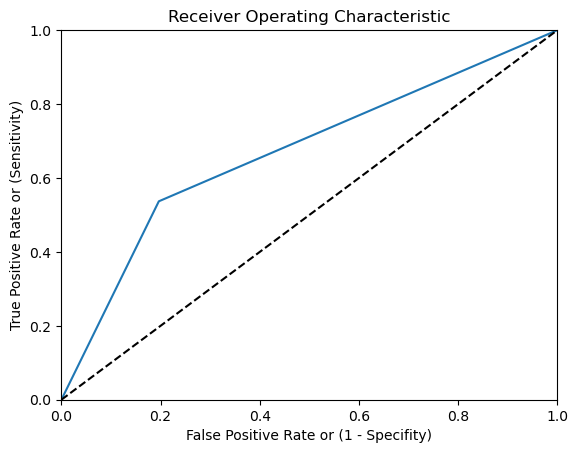

Classification with solver newton-cg and C value 1.0
Accuracy: 0.686 (0.081)
F1 score: 0.625 (0.153)
AUC is:  0.6490601503759399
              precision    recall  f1-score   support

           0       0.83      0.39      0.53       112
           1       0.56      0.91      0.69        95

    accuracy                           0.63       207
   macro avg       0.69      0.65      0.61       207
weighted avg       0.71      0.63      0.61       207

Confusion Matrix: 
 [[44 68]
 [ 9 86]]


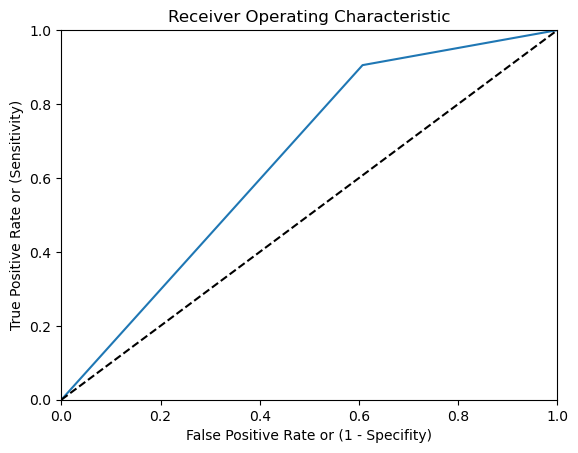

c:\Users\Eero\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification with solver lbfgs and C value 1.0
Accuracy: 0.686 (0.081)
F1 score: 0.625 (0.153)
AUC is:  0.6657424812030075
              precision    recall  f1-score   support

           0       0.67      0.79      0.73       112
           1       0.69      0.54      0.60        95

    accuracy                           0.68       207
   macro avg       0.68      0.67      0.67       207
weighted avg       0.68      0.68      0.67       207

Confusion Matrix: 
 [[89 23]
 [44 51]]


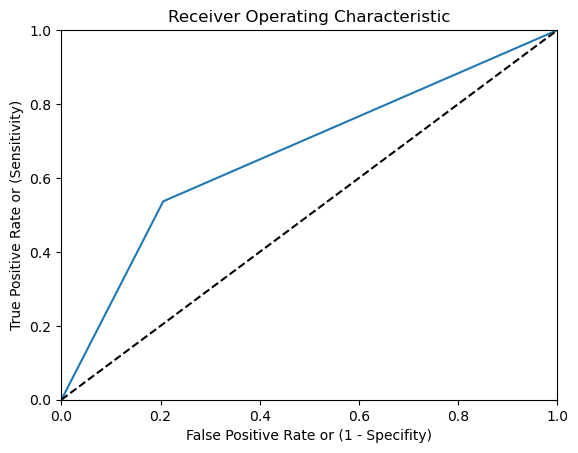

In [42]:
from numpy import mean
from numpy import std

solvers = ["liblinear", "newton-cg", "lbfgs"]
c_values = [1.0]

for solver in solvers:
    for c in c_values:
        model = LogisticRegression(C=c, multi_class='auto', solver=solver) 
        model.fit(train_input, train_output)    # Training the model 
        predicted = model.predict(X_test_norm)  # Predicting labels for our test set using trained model

        # 5-fold cross validation
        accuracy_scores = cross_val_score(model, X_test_norm, test_output, cv=5, scoring='accuracy')
        f1_scores = cross_val_score(model, X_test_norm, test_output, cv=5, scoring='f1')

        # results
        print(f"Classification with solver {solver} and C value {c}")
        print('Accuracy: %.3f (%.3f)' % (mean(accuracy_scores), std(accuracy_scores)))
        print('F1 score: %.3f (%.3f)' % (mean(f1_scores), std(f1_scores)))
        #print(classification_report(test_output, predicted))#, output_dict=True, digits=3))
        evaluate_on_training_set(test_output, predicted)
        reportDict = classification_report(test_output, predicted, output_dict=True)